## Imports

In [56]:
import re

import anndata as ad
import cellrank as cr
import jax
import magic
import matplotlib.pyplot as plt
import numpy as np
import orbax
import pandas as pd
import seaborn as sns
import yaml
from jax.nn import gelu
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from tqdm import tqdm

import spacetime
from spacetime import potentials, steps

In [57]:
# Set default Seaborn style
sns.set_theme("paper", "whitegrid")

## Load the data

In [58]:
# Load the data
adata = ad.read_h5ad(
    "/home/ghuizing/Documents/data/artista/artista_traj_processed.h5ad"
)

# Normalize the gene expression
adata.obsm["X_pca_harmony"] = adata.obsm["X_pca_harmony"][:, :20]
adata.obsm["X_pca_harmony"] /= adata.obsm["X_pca_harmony"].max()

## Load the weights

In [59]:
# Initialize the model.
step = steps.ExplicitStep()
my_model = spacetime.SpaceTime(
    potential=potentials.MLPPotential([128, 128], activation=gelu),
    proximal_step=step,
)

# Load the config
weights_path = "/home/ghuizing/Documents/runs/artista_growth_june_quadratic_f2js21i6/"
with open(weights_path + "config.yaml") as f:
    config = yaml.safe_load(f)

# Print the fused parameter
print("Quadratic weight:", config["model"]["quadratic_weight"])

# Define the checkpoint manager.
options = orbax.checkpoint.CheckpointManagerOptions(
    save_interval_steps=1,
    max_to_keep=1,
    best_fn=lambda x: x["loss"],
    best_mode="min",
)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    f"{weights_path}/checkpoints",
    orbax.checkpoint.PyTreeCheckpointer(),
    options=options,
)

# Restore the model.
best_epoch = checkpoint_manager.best_step()
my_model.params = checkpoint_manager.restore(best_epoch)

Quadratic weight: 0.001


## Panel A: Compute potential

In [60]:
# Compute the potential
potential_fn = lambda x: my_model.potential.apply(my_model.params, x)
adata.obs["potential"] = np.array(potential_fn(adata.obsm["X_pca_harmony"]))

# Save all this in a csv
df = pd.DataFrame(adata.obs)
df[["iso_1", "iso_2"]] = adata.obsm["X_isomap"]
df.to_csv("/home/ghuizing/Documents/artista_potential.csv")

## Penl B: Plot trajectory

In [61]:
# Compute the velocities
velo_fn = lambda x: -jax.vmap(jax.grad(potential_fn))(x)
adata.obsm["X_velo"] = np.array(velo_fn(adata.obsm["X_pca_harmony"]))

In [62]:
palette = {
    "IMN": "#FFE368",
    "dpEX": "#FF6666",
    "mpEX": "#d33f6a",
    "nptxEX": "#ef9708",
    "rIPC1": "#2CCD39",
    "rIPC2": "#7E0AD1",
    "reaEGC": "#00F2CE",
    "wntEGC": "#1ce6ff",
}

100%|██████████| 5904/5904 [00:04<00:00, 1409.17cell/s]


saving figure to file ./figures/scvelo_artista_velocities.svg


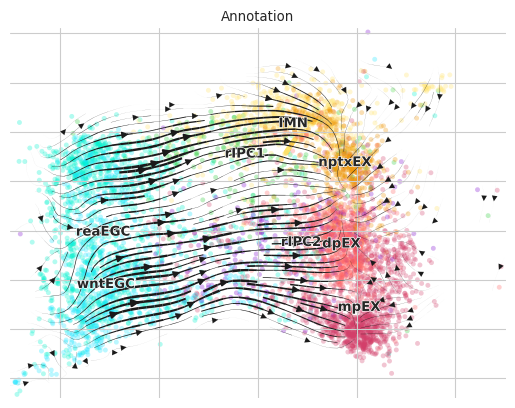

In [63]:
vk = cr.kernels.VelocityKernel(
    adata, attr="obsm", xkey="X_pca_harmony", vkey="X_velo"
).compute_transition_matrix()
vk.plot_projection(
    basis="isomap",
    recompute=True,
    color="Annotation",
    save="artista_velocities.svg",
    palette=palette,
    s=50,
)

## Fit gene regressions

In [64]:
# Subset to trajectory 1
adata = adata[adata.obs["Annotation"].isin(["reaEGC", "rIPC1", "IMN", "nptxEX"])].copy()

In [65]:
magic_operator = magic.MAGIC()
magic_operator.fit(adata.obsm["X_pca_harmony"])
diff_op_t = np.linalg.matrix_power(magic_operator.diff_op.A, 3)
adata.X = diff_op_t @ np.log1p(adata.layers["counts"].A)

Running MAGIC on 2715 cells and 20 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.12 seconds.
  Calculating affinities...
  Calculated affinities in 0.10 seconds.
Calculated graph and diffusion operator in 0.22 seconds.


In [66]:
# We want to regress gene expression from the potential
x_train = np.array(adata.obs["potential"]).reshape(-1, 1).astype(np.float64)

# The model is a spline regression
model = make_pipeline(
    SplineTransformer(
        knots="quantile",
        extrapolation="continue",
    ),
    LinearRegression(),
)

# Fit the model for each gene and keep the score and argmax
for gene in tqdm(adata.var_names):

    # The target gene expression
    y_train = adata[:, gene].X.ravel()

    # Fit the model
    model.fit(x_train, y_train)

    # Store the results
    adata.var.loc[gene, "score"] = model.score(x_train, y_train)
    adata.var.loc[gene, "argmax"] = model.predict(np.sort(x_train, axis=0)).argmax()

100%|██████████| 10000/10000 [01:00<00:00, 164.85it/s]


In [67]:
# Remove genes with a perfect score (they are always 0)
idx = np.array(adata.var["score"]) != 1.0
adata = adata[:, idx].copy()

## Panel C: show trends

In [68]:
def extract_gene_name(text):
    # Regular expression patterns ordered by priority
    patterns = [
        r"(\b\w+)\s*\|",  # gene name without hint (highest priority)
        r"(\b\w+)\[hs\]",  # [hs] hint
        r"(\b\w+)\[nr\]",  # [nr] hint
        r"(\b\w+)\[.*?\]",  # any other hint
        r"(AMEX[\da-zA-Z]+)",  # AMEX code
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return match.group(1)

    return text  # default return if no pattern matches


adata.var["clean_name"] = [extract_gene_name(g) for g in adata.var_names]

In [69]:
n_stages = 10
n_genes = 3
i_list = np.arange(0, adata.n_obs, adata.n_obs // n_stages)

gene_names = []
for k in range(len(i_list) - 1):

    # We'll look for the best genes in this interval
    i_min, i_max = i_list[k], i_list[k + 1]
    order_idx = i_min <= np.array(adata.var["argmax"])
    order_idx &= np.array(adata.var["argmax"]) < i_max

    for j, i in enumerate(
        np.where(order_idx)[0][
            np.argsort(np.array(adata.var["score"])[order_idx])[::-1][:n_genes]
        ]
    ):
        gene_names.append(adata.var_names[i])

In [70]:
gene_names = [g for g in gene_names if "AMEX" not in adata.var.loc[g, "clean_name"]]
gene_names = [g for g in gene_names if "_" not in adata.var.loc[g, "clean_name"]]

In [71]:
def plot_gene_trends(gene_names):

    fig, axes = plt.subplots(
        2, 1, gridspec_kw={"height_ratios": [1, 25]}, figsize=(8, 5)
    )

    x_train = np.array(adata.obs["potential"])  # The potential
    X = np.zeros((len(gene_names), len(x_train)))  # Initialize the matrix to plot

    sorted_genes_names = adata.var.loc[gene_names, "argmax"].sort_values().index

    # Iterate of the genes
    for i, g in enumerate(sorted_genes_names):

        # Fit the model
        y_train = adata[:, g].X.ravel()
        model.fit(x_train.reshape(-1, 1), y_train)

        # Populate the matrix
        X[i] = model.predict(x_train.reshape(-1, 1))

    # Order the potential
    X = X[:, np.argsort(x_train)]

    # Normalize rows
    X = X - X.min(axis=1)[:, None]
    X = X / X.max(axis=1)[:, None]
    implot = axes[1].imshow(X, aspect="auto", cmap="viridis", interpolation="none")

    # Set sorted_genes_names as yticks with small font size
    axes[1].set_yticks(
        np.arange(0, X.shape[0]),
        adata.var.loc[sorted_genes_names, "clean_name"].str.capitalize(),
        fontsize=6,
        fontstyle="italic",
    )
    axes[1].grid(None)

    implot2 = axes[0].imshow(
        adata.obs["Annotation"].cat.codes.to_numpy().reshape(1, -1),
        aspect="auto",
        cmap="tab10",
        interpolation="none",
    )
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["bottom"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].spines["left"].set_visible(False)

    fig.colorbar(implot)
    fig.colorbar(implot2)

    plt.suptitle("Gene trends along neuron regeneration")
    plt.savefig(
        "/home/ghuizing/Documents/notebooks/trajectories/figures/artista_gene_trends.svg"
    )
    plt.show()

    return sorted_genes_names

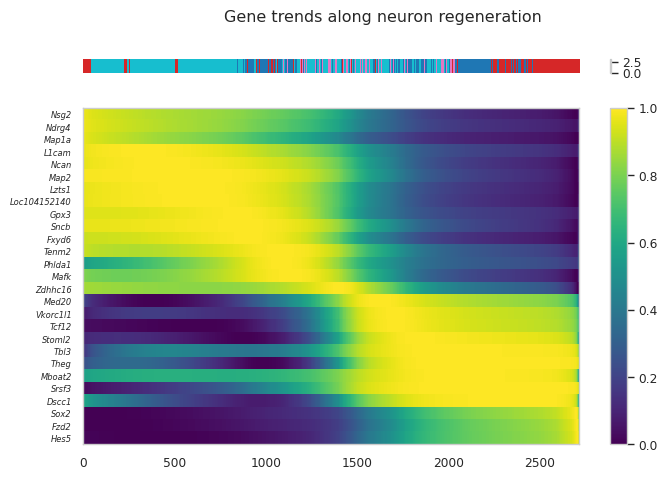

In [72]:
sorted_genes_names = plot_gene_trends(gene_names)

## Panel D: compare to paper

In [74]:
palette = {
    "reaEGC": "#27cbb4",
    "rIPC1": "#3ebb47",
    "IMN": "#f8d349",
    "nptxEX": "#e28c00",
}

In [75]:
def plot_cells(gene):
    sns.scatterplot(
        x=adata.obs["potential"],
        y=adata[:, gene].X.ravel(),
        hue=adata.obs["Annotation"],
        hue_order=["reaEGC", "rIPC1", "IMN", "nptxEX"],
        palette=palette,
        s=5,
        alpha=1.0,
    )

    model.fit(
        adata.obs["potential"].to_numpy().reshape(-1, 1),
        adata[:, gene].X.ravel(),
    )
    xx = np.linspace(
        adata.obs["potential"].min(), adata.obs["potential"].quantile(0.95), 100
    )
    yy = model.predict(xx.reshape(-1, 1))
    sns.lineplot(x=xx, y=yy)
    sns.despine()

    plt.xlim(right=adata.obs["potential"].quantile(0.99))
    plt.title(gene.capitalize(), fontstyle="italic")
    plt.legend(markerscale=3)
    plt.savefig(
        "/home/ghuizing/Documents/notebooks/trajectories/figures/artista_gene_"
        + gene
        + ".svg"
    )
    plt.show()

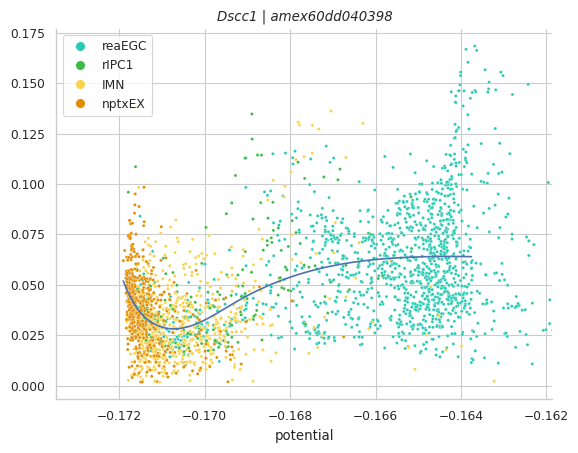

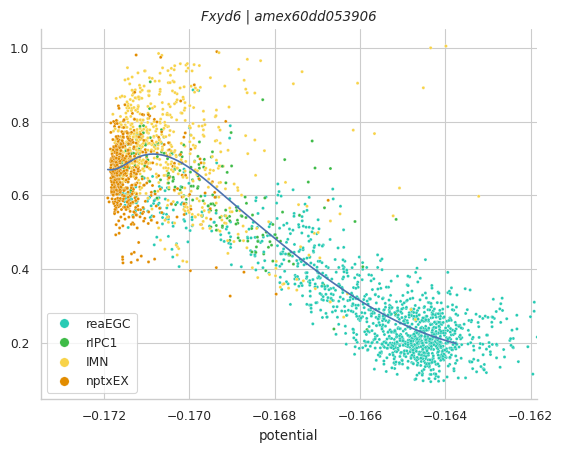

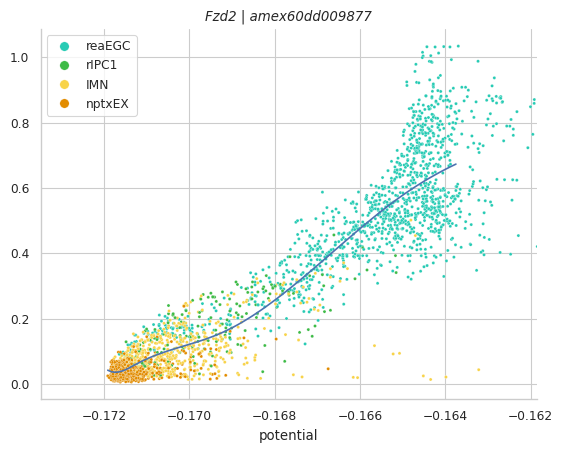

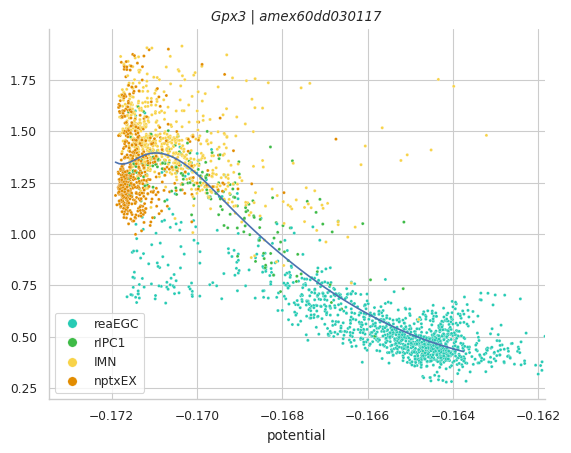

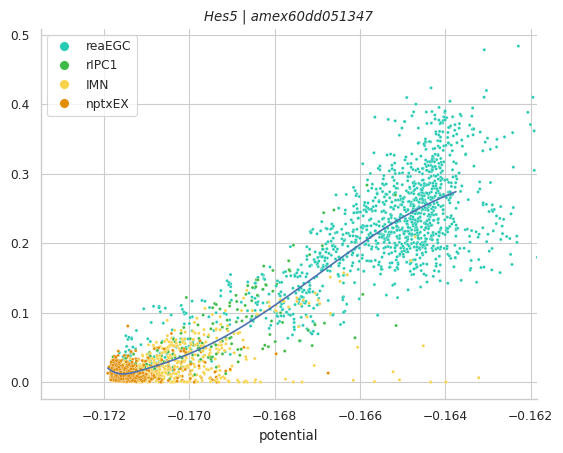

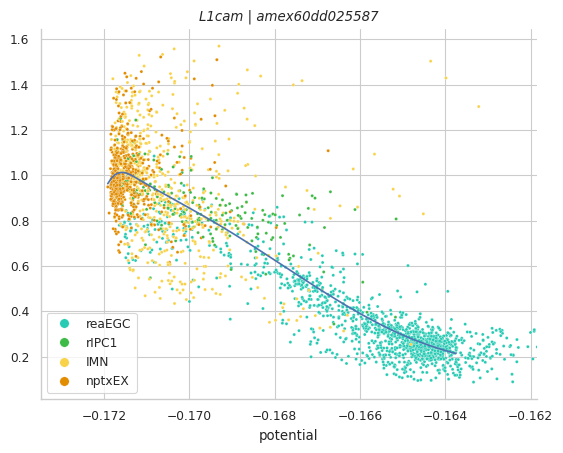

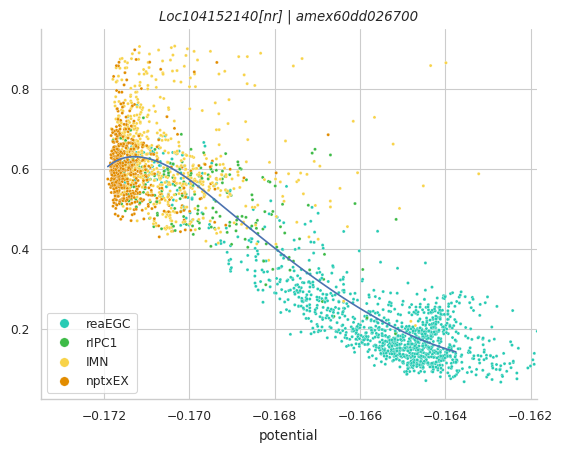

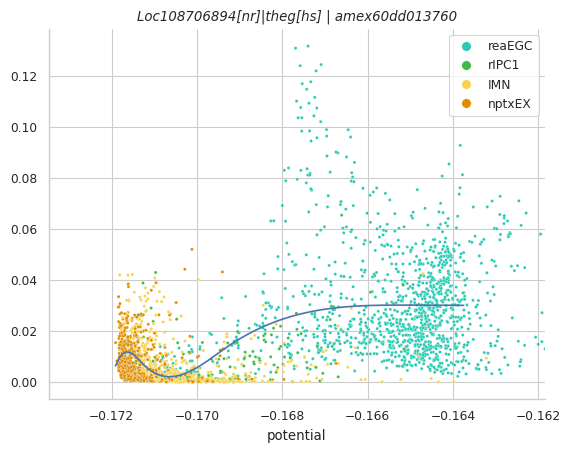

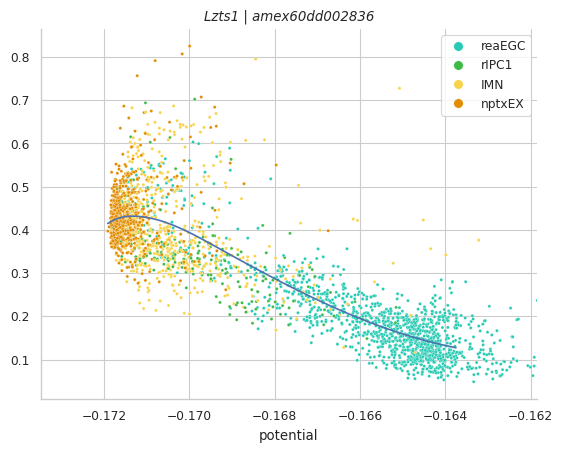

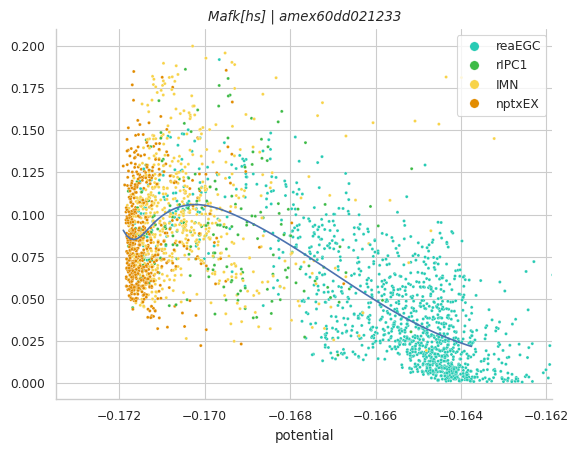

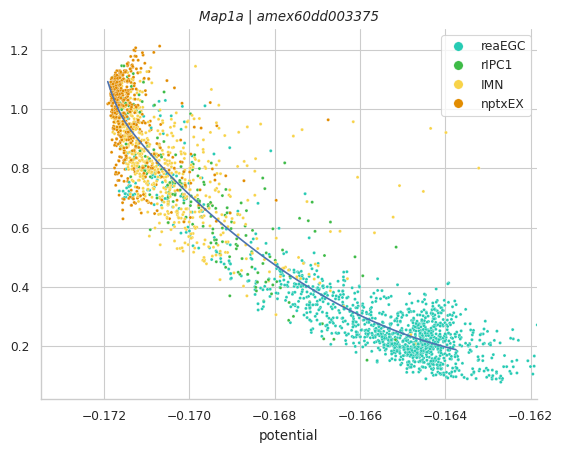

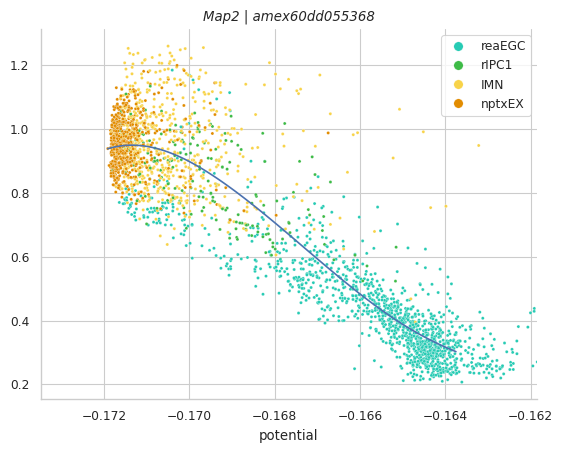

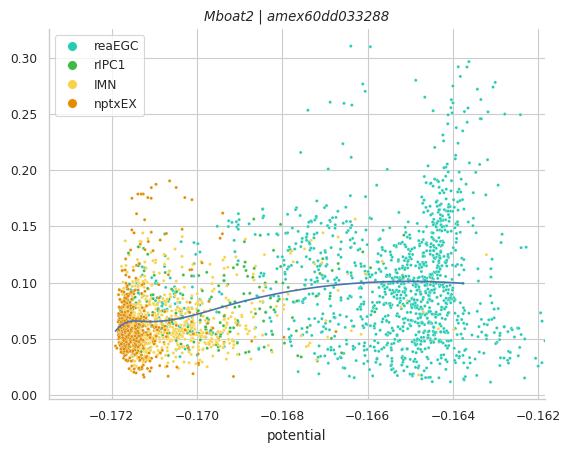

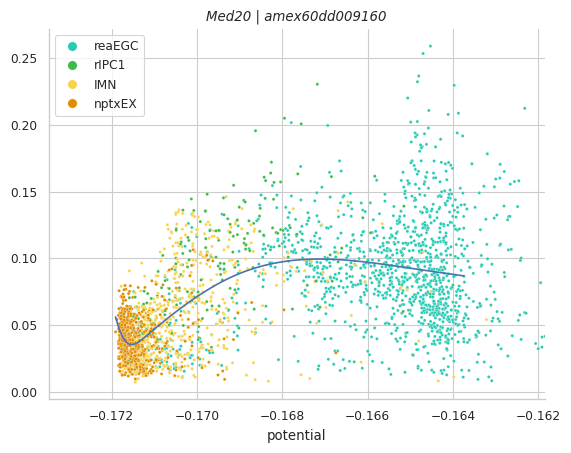

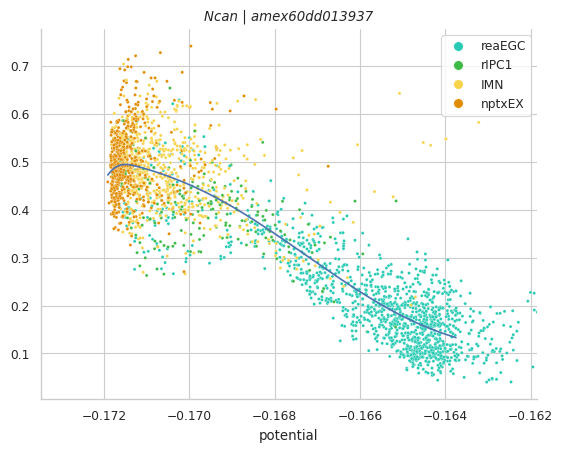

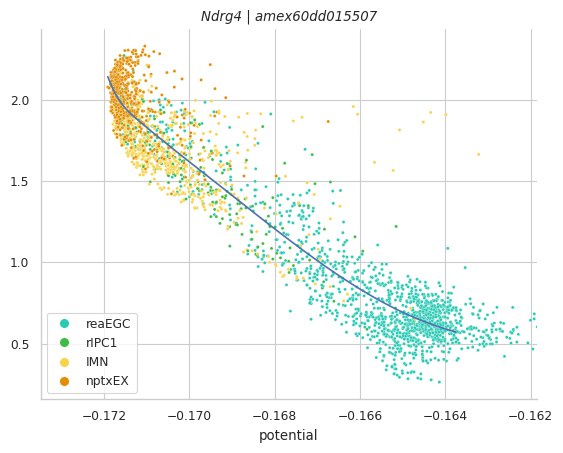

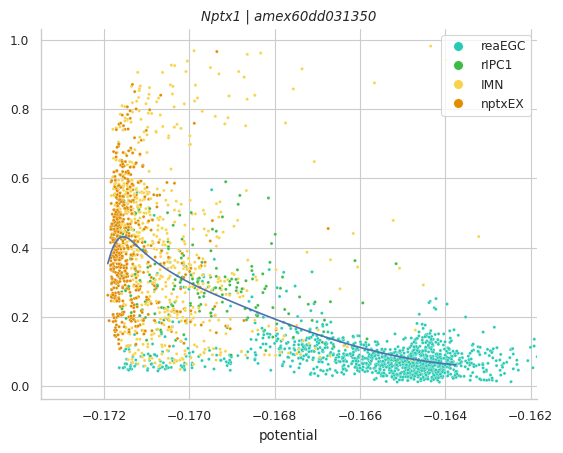

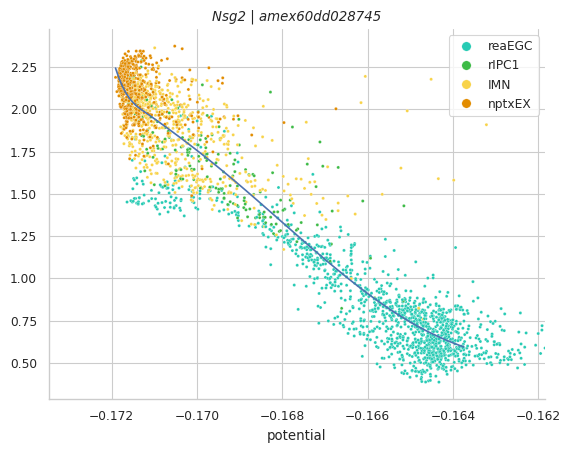

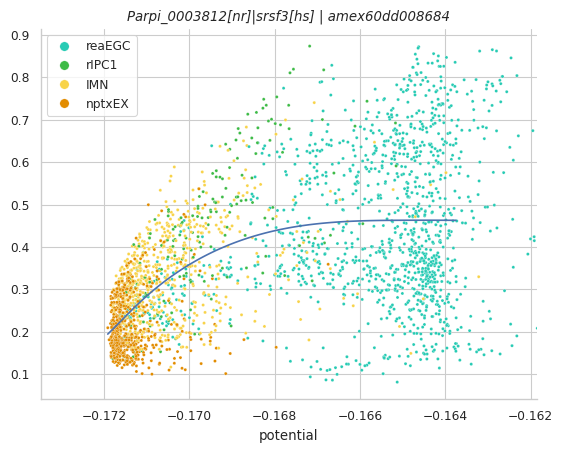

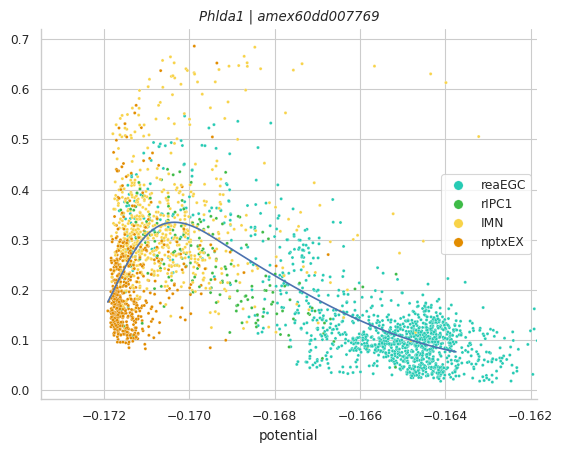

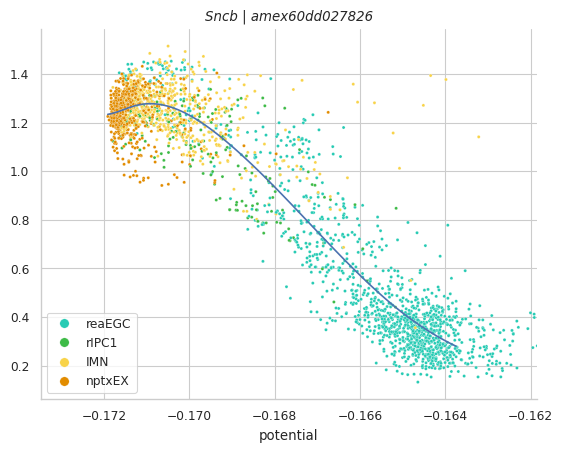

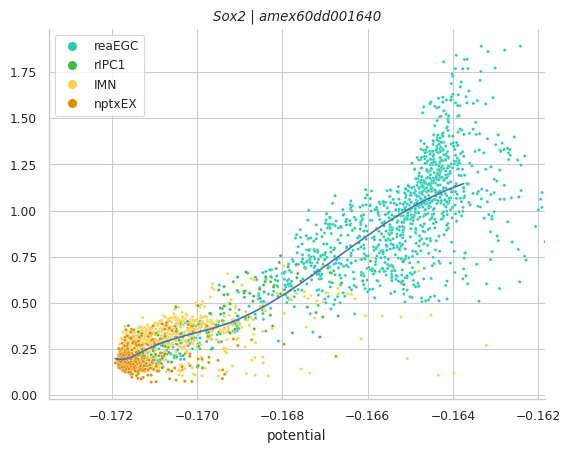

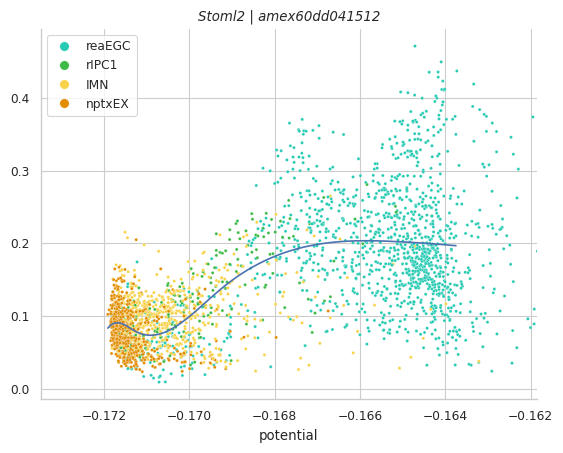

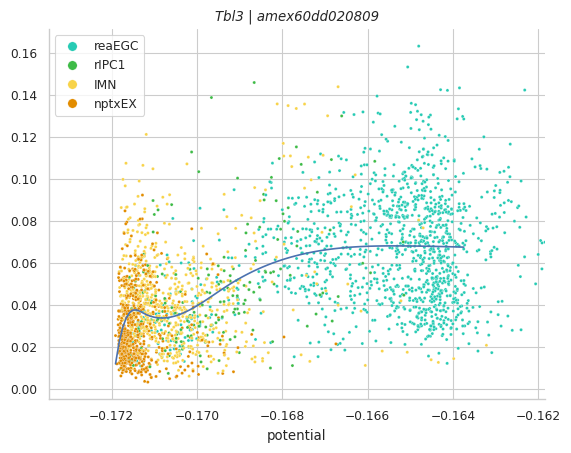

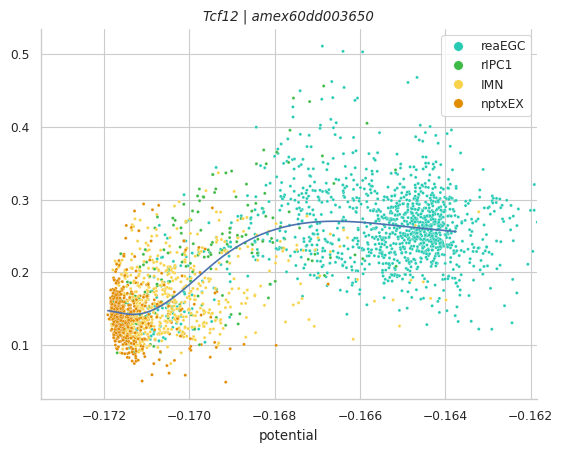

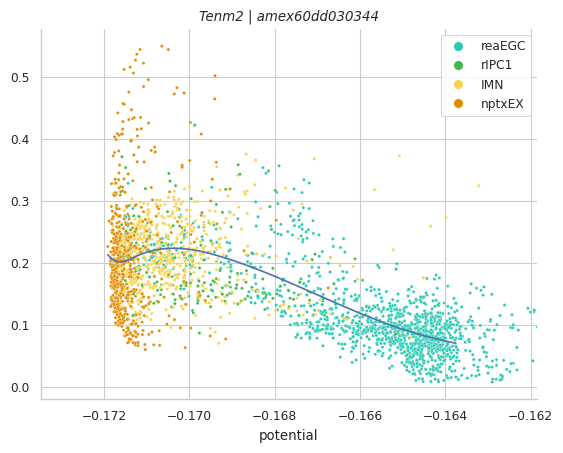

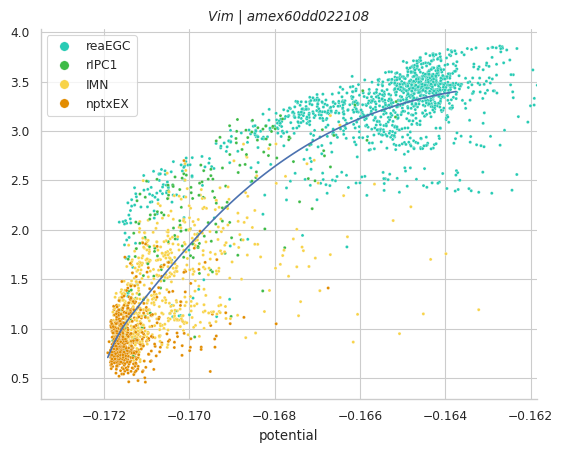

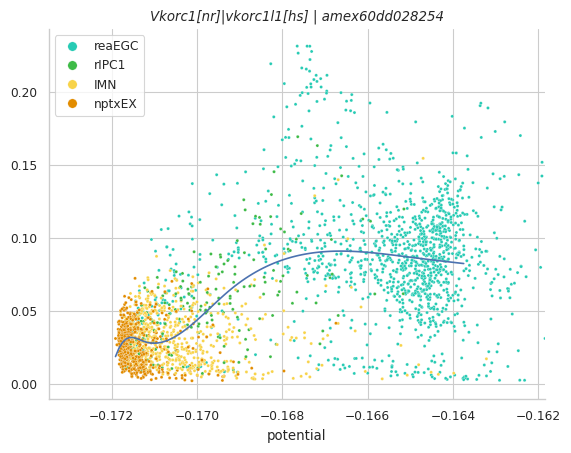

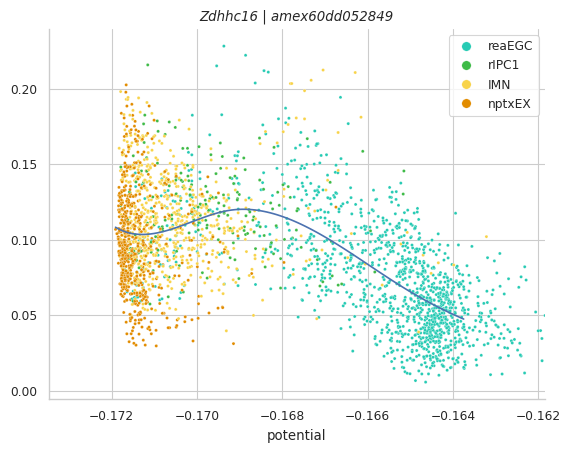

In [76]:
for gene in np.union1d(
    sorted_genes_names,
    [
        "NPTX1 | AMEX60DD031350",
        "VIM | AMEX60DD022108",
    ],
):
    plot_cells(gene)

In [77]:
for gene in adata.var.loc[sorted_genes_names, "clean_name"]:
    term = gene + " neuron regeneration"
    print(gene, "\t", f"https://pubmed.ncbi.nlm.nih.gov/?term={term.replace(' ', '+')}")

NSG2 	 https://pubmed.ncbi.nlm.nih.gov/?term=NSG2+neuron+regeneration
NDRG4 	 https://pubmed.ncbi.nlm.nih.gov/?term=NDRG4+neuron+regeneration
MAP1A 	 https://pubmed.ncbi.nlm.nih.gov/?term=MAP1A+neuron+regeneration
L1CAM 	 https://pubmed.ncbi.nlm.nih.gov/?term=L1CAM+neuron+regeneration
NCAN 	 https://pubmed.ncbi.nlm.nih.gov/?term=NCAN+neuron+regeneration
MAP2 	 https://pubmed.ncbi.nlm.nih.gov/?term=MAP2+neuron+regeneration
LZTS1 	 https://pubmed.ncbi.nlm.nih.gov/?term=LZTS1+neuron+regeneration
LOC104152140 	 https://pubmed.ncbi.nlm.nih.gov/?term=LOC104152140+neuron+regeneration
GPX3 	 https://pubmed.ncbi.nlm.nih.gov/?term=GPX3+neuron+regeneration
SNCB 	 https://pubmed.ncbi.nlm.nih.gov/?term=SNCB+neuron+regeneration
FXYD6 	 https://pubmed.ncbi.nlm.nih.gov/?term=FXYD6+neuron+regeneration
TENM2 	 https://pubmed.ncbi.nlm.nih.gov/?term=TENM2+neuron+regeneration
PHLDA1 	 https://pubmed.ncbi.nlm.nih.gov/?term=PHLDA1+neuron+regeneration
MAFK 	 https://pubmed.ncbi.nlm.nih.gov/?term=MAFK+neuron+r

## Panel E: TF targets

In [78]:
df_tf = pd.read_csv(
    "/home/ghuizing/Documents/data/trrust_rawdata.human.tsv", sep="\t", header=None
)
df_tf.columns = ["TF", "Target", "Mode", "References"]
df_tf = df_tf[df_tf["Target"].isin(adata.var["clean_name"])]

In [79]:
df_tf

TF  Target        Mode        References
1       AATF  CDKN1A     Unknown          17157788
7       ABL1    BCL6  Repression          15509806
8       ABL1   CCND2  Activation          15509806
9       ABL1  CDKN1A  Activation  11753601;9916993
12      ABL1   FOXO3  Activation          15509806
...      ...     ...         ...               ...
9385  ZNF382   STAT3  Repression          20682794
9387  ZNF383     JUN  Repression          15964543
9391   ZNF76  CDKN1A  Repression          15280358
9392   ZNF76  PCYT1A  Activation          14702349
9393   ZNF76  TALDO1     Unknown          14702349

[3763 rows x 4 columns]

In [80]:
for tf in tqdm(df_tf["TF"].unique()):
    idx = df_tf["TF"] == tf
    adata.var[tf] = 0.0

    # Iterate over rows of df_tf[idx]:
    for target in df_tf.loc[idx, "Target"]:
        adata.var.loc[adata.var["clean_name"] == target, tf] = 1

100%|██████████| 591/591 [00:03<00:00, 181.41it/s]


In [81]:
from scipy.stats import ranksums

df_tf_stats = pd.DataFrame(index=df_tf["TF"].unique())
for tf in tqdm(df_tf_stats.index):

    idx_target = adata.var[tf] > 0
    target_scores = adata.var.loc[idx_target, "score"].values.astype(float)

    idx_nontarget = adata.var[tf] == 0
    nontarget_scores = adata.var.loc[idx_nontarget, "score"].values.astype(float)

    stat, p_value = ranksums(target_scores, nontarget_scores, alternative="greater")
    df_tf_stats.loc[tf, ["stat", "p_value", "n_targets"]] = (
        stat,
        p_value,
        idx_target.sum(),
    )

100%|██████████| 591/591 [00:01<00:00, 538.03it/s]


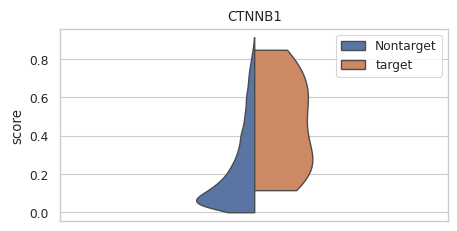

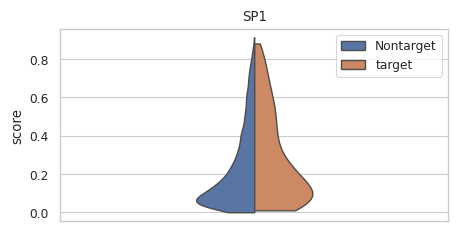

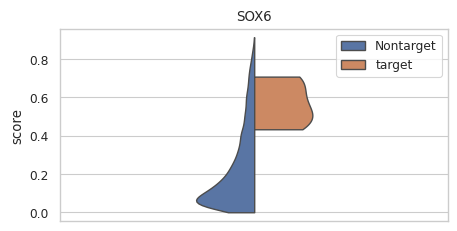

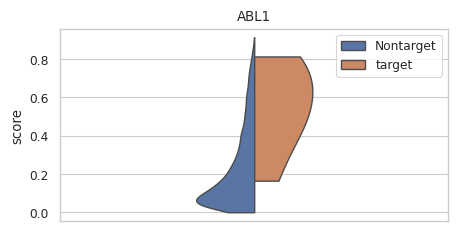

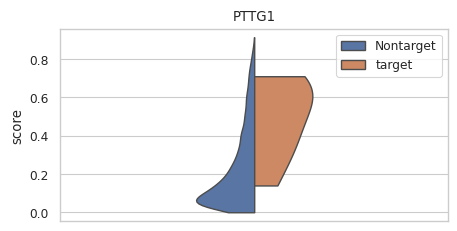

In [82]:
for tf in df_tf_stats.sort_values("p_value").index[:5]:
    idx = ["target" if x > 0 else "Nontarget" for x in adata.var[tf]]
    fig, ax = plt.subplots(figsize=(5, 2.5))
    plt.title(tf)
    sns.violinplot(
        data=adata.var,
        hue=idx,
        y="score",
        split=True,
        inner=None,
        cut=0,
        ax=ax,
        width=0.3,
    )
    plt.show()

In [83]:
idx = df_tf_stats["p_value"] < 0.05
for tf in df_tf_stats[idx].sort_values("p_value").index:
    term = tf + " neuron regeneration"
    print(tf, "\t", f"https://pubmed.ncbi.nlm.nih.gov/?term={term.replace(' ', '+')}")

CTNNB1 	 https://pubmed.ncbi.nlm.nih.gov/?term=CTNNB1+neuron+regeneration
SP1 	 https://pubmed.ncbi.nlm.nih.gov/?term=SP1+neuron+regeneration
SOX6 	 https://pubmed.ncbi.nlm.nih.gov/?term=SOX6+neuron+regeneration
ABL1 	 https://pubmed.ncbi.nlm.nih.gov/?term=ABL1+neuron+regeneration
PTTG1 	 https://pubmed.ncbi.nlm.nih.gov/?term=PTTG1+neuron+regeneration
REST 	 https://pubmed.ncbi.nlm.nih.gov/?term=REST+neuron+regeneration
MYC 	 https://pubmed.ncbi.nlm.nih.gov/?term=MYC+neuron+regeneration
NKX2-5 	 https://pubmed.ncbi.nlm.nih.gov/?term=NKX2-5+neuron+regeneration
MYCN 	 https://pubmed.ncbi.nlm.nih.gov/?term=MYCN+neuron+regeneration
E2F1 	 https://pubmed.ncbi.nlm.nih.gov/?term=E2F1+neuron+regeneration
LEF1 	 https://pubmed.ncbi.nlm.nih.gov/?term=LEF1+neuron+regeneration
TSC22D3 	 https://pubmed.ncbi.nlm.nih.gov/?term=TSC22D3+neuron+regeneration
NFIC 	 https://pubmed.ncbi.nlm.nih.gov/?term=NFIC+neuron+regeneration
HBP1 	 https://pubmed.ncbi.nlm.nih.gov/?term=HBP1+neuron+regeneration
PITX1 	 

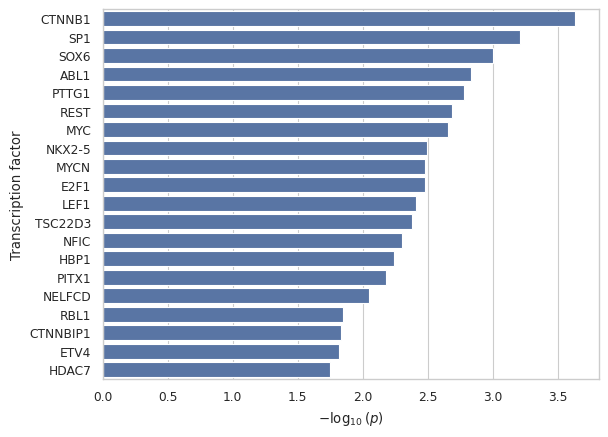

In [84]:
idx = df_tf_stats["p_value"] < 0.05
tf_names = df_tf_stats[idx].sort_values("p_value").index[:20]
sns.barplot(y=tf_names, x=-np.log10(df_tf_stats.loc[tf_names, "p_value"]))
plt.ylabel("Transcription factor")
# Math formatting -log(p)
plt.xlabel(r"$-\log_{10}(p)$")
plt.savefig(
    "/home/ghuizing/Documents/notebooks/trajectories/figures/artista_tf_significance.svg"
)